In [297]:
import os, re, cv2, random, math
import requests
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from PIL import Image
from bs4 import BeautifulSoup
from urllib.parse import urljoin

In [5]:
class ImageCoinCrawler:
    def __init__(self):
        self.download_folder = 'coin_images'

        if not os.path.exists('visited_pages.csv'):
            self.visited_pages = []
        else:
            self.visited_pages = pd.read_csv('visited_pages.csv')['0'].values.tolist()

        if not os.path.exists('image_urls.csv'):
            self.image_urls = []
        else:
            self.image_urls = pd.read_csv('image_urls.csv')['0'].values.tolist()

    def is_valid_image_url(self, url):
        image_extensions = ['.jpg', '.jpeg', '.png', '.gif']
        return any(url.lower().endswith(ext) for ext in image_extensions)
    
    def is_valid_image_name(self, url):
        image_contains = ['moeda', 'moedas', 'coin', 'centavo', 'centavos', 'real', 'reais', 'dinheiro', 'money', 'currency']
        return any(nm in url.lower() for nm in image_contains)
    
    def update_visited_pages(self):
        pd.DataFrame(self.visited_pages).to_csv('visited_pages.csv', index=False)

    def update_image_urls(self):
        pd.DataFrame(self.image_urls).to_csv('image_urls.csv', index=False)

    def get_image_urls(self, query, num_results=50):

        results = search(query, num_results=num_results, sleep_interval=15, timeout=3, lang='pt')
        for page_url in results:
            try:
                if page_url in self.visited_pages:
                    continue
                
                print('loading page: ', page_url, '...')
                self.visited_pages.append(page_url)

                response = requests.get(page_url)
                soup = BeautifulSoup(response.text, 'html.parser')

                for img_tag in soup.find_all('img'):
                    img_url = img_tag.get('src')

                    if not self.is_valid_image_url(img_url):
                        continue
                    
                    full_img_url = urljoin(page_url, img_url)
                    if full_img_url not in self.image_urls:
                        print('---------- found image: ', full_img_url)
                        self.image_urls.append(full_img_url)
                        self.update_image_urls()

                self.update_visited_pages()
            except:
                continue

    def download_images(self, urls):
        if not os.path.exists(self.download_folder):
            os.makedirs(self.download_folder)

        for i, url in enumerate(urls):
            try:
                response = requests.get(url)
                file_ext = os.path.splitext(url)[-1].split('?')[0]
                file_path = os.path.join(self.download_folder, f'coin_{i}{file_ext}')
                with open(file_path, 'wb') as f:
                    f.write(response.content)
            except:
                continue

In [ ]:
coin_query = 'moedas brasileiras'
num_images = 150

imageCoin = ImageCoinCrawler()
imageCoin.get_image_urls(coin_query, num_results=num_images)

imageCoin.download_images(imageCoin.image_urls)

In [324]:
def get_year(string):
    year = re.findall(r'\d{4}', string)
    if year:
        return year[0]
    else:
        return None
    
def resize_images(folder, width, height):
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            resized_img = img.resize((width, height))
            resized_img.save(img_path)

def create_rotations(folder):
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            file_ext = os.path.splitext(filename)[-1].split('?')[0]
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            rotations = [45, 90, 135, 180, 225, 270]
            for rot in rotations:
                img_rotated = img.rotate(rot)
                print(os.path.join(folder, f'{filename[:-4]}_rot{rot}{file_ext}'))
                img_rotated.save(os.path.join(folder, f'{filename[:-4]}_rot{rot}{file_ext}'))

def transform_bw(folder):
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            file_ext = os.path.splitext(filename)[-1].split('?')[0]
            img_path = os.path.join(folder, filename)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Parametros: imagem e mediana de todos os pixels na área do kernel
            img = cv2.medianBlur(img, 5)
            img = cv2.equalizeHist(img)
            img = cv2.GaussianBlur(img, (5, 5), 0)
            img = cv2.GaussianBlur(img, (7, 7), 0)

            th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,8)

            plt.imsave(os.path.join(folder + 'bw/', f'{filename[:-4]}_bw{file_ext}'), th3, cmap='gray')

def transform_gray(folder):
    for filename in os.listdir(folder):
        if (filename.endswith('.jpg') or filename.endswith('.png')) and not filename.endswith('_bw.jpg'):
            file_ext = os.path.splitext(filename)[-1].split('?')[0]
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            img_bw = img.convert('L')
            img_bw.save(os.path.join(folder + 'gs/', f'{filename[:-4]}_gs{file_ext}'))   


In [31]:
def rename_files(folder, prefix, has_year=True):
    for i, filename in enumerate(os.listdir(folder)):
        try:
            file_ext = os.path.splitext(filename)[-1].split('?')[0]
            year = ''
            if has_year:
                year = f'_{get_year(filename)}'
                
            print(os.path.join(folder, f'{prefix}{year}_{i}{file_ext}'))
            os.rename(os.path.join(folder, filename), os.path.join(folder, f'{prefix}{year}_{i}{file_ext}'))
        except:
            continue

In [30]:
rename_files('coin_images/test/', 'test', has_year=False)

coin_images/test/test__0.png
coin_images/test/test__1.png
coin_images/test/test__2.jpg
coin_images/test/test__3.jpg
coin_images/test/test__4.jpg
coin_images/test/test__5.jpg
coin_images/test/test__6.jpg
coin_images/test/test__7.jpg
coin_images/test/test__8.jpg
coin_images/test/test__9.jpg
coin_images/test/test__10.png
coin_images/test/test__11.jpg
coin_images/test/test__12.jpg
coin_images/test/test__13.jpg
coin_images/test/test__14.jpg
coin_images/test/test__15.jpg
coin_images/test/test__16.jpg
coin_images/test/test__17.jpg
coin_images/test/test__18.jpg
coin_images/test/test__19.jpg
coin_images/test/test__20.png
coin_images/test/test__21.png
coin_images/test/test__22.jpg
coin_images/test/test__23.jpg
coin_images/test/test__24.jpg
coin_images/test/test__25.jpg
coin_images/test/test__26.jpg
coin_images/test/test__27.jpg
coin_images/test/test__28.jpg
coin_images/test/test__29.jpg
coin_images/test/test__30.jpg
coin_images/test/test__31.jpg
coin_images/test/test__32.jpg
coin_images/test/tes

In [26]:
rename_files('coin_images/train/1-c/', '1-c')
rename_files('coin_images/train/5-c/', '5-c')
rename_files('coin_images/train/10-c/', '10-c')
rename_files('coin_images/train/25-c/', '25-c')
rename_files('coin_images/train/50-c/', '50-c')
rename_files('coin_images/train/1-r/', '1-r')

coin_images/train/1-c/1-c_1997_0.jpg
coin_images/train/1-c/1-c_2002_1.jpg
coin_images/train/1-c/1-c_1995_2.jpg
coin_images/train/1-c/1-c_1994_3.jpg
coin_images/train/1-c/1-c_1994_4.jpg
coin_images/train/1-c/1-c_1995_5.jpg
coin_images/train/1-c/1-c_1997_6.jpg
coin_images/train/1-c/1-c_2004_7.jpg
coin_images/train/1-c/1-c_1994_8.jpg
coin_images/train/1-c/1-c_1995_9.jpg
coin_images/train/1-c/1-c_2002_10.jpg
coin_images/train/1-c/1-c_2003_11.jpg
coin_images/train/1-c/1-c_2003_12.jpg
coin_images/train/1-c/1-c_2004_13.jpg
coin_images/train/5-c/5-c_1994_0.jpg
coin_images/train/5-c/5-c_1994_1.jpg
coin_images/train/5-c/5-c_1995_2.jpg
coin_images/train/5-c/5-c_1997_3.jpg
coin_images/train/5-c/5-c_2006_4.jpg
coin_images/train/5-c/5-c_2007_5.jpg
coin_images/train/5-c/5-c_2011_6.jpg
coin_images/train/5-c/5-c_2011_7.jpg
coin_images/train/5-c/5-c_1994_8.jpg
coin_images/train/5-c/5-c_1994_9.jpg
coin_images/train/5-c/5-c_1997_10.jpg
coin_images/train/5-c/5-c_1997_11.jpg
coin_images/train/5-c/5-c_2003_1

In [318]:
#ajusta o tamanho das imagens para 70% do tamanho original
resize_images('coin_images/coins/train/1-c/', 716, 716)
resize_images('coin_images/coins/train/5-c/', 716, 716)
resize_images('coin_images/coins/train/10-c/', 716, 716)
resize_images('coin_images/coins/train/25-c/', 716, 716)
resize_images('coin_images/coins/train/50-c/', 716, 716)
resize_images('coin_images/coins/train/1-r/', 716, 716)

In [319]:
create_rotations('coin_images/coins/train/1-c/')
create_rotations('coin_images/coins/train/5-c/')
create_rotations('coin_images/coins/train/10-c/')
create_rotations('coin_images/coins/train/25-c/')
create_rotations('coin_images/coins/train/50-c/')
create_rotations('coin_images/coins/train/1-r/')

coin_images/coins/train/1-c/1-c_1994_3_rot45.jpg
coin_images/coins/train/1-c/1-c_1994_3_rot90.jpg
coin_images/coins/train/1-c/1-c_1994_3_rot135.jpg
coin_images/coins/train/1-c/1-c_1994_3_rot180.jpg
coin_images/coins/train/1-c/1-c_1994_3_rot225.jpg
coin_images/coins/train/1-c/1-c_1994_3_rot270.jpg
coin_images/coins/train/1-c/1-c_1994_4_rot45.jpg
coin_images/coins/train/1-c/1-c_1994_4_rot90.jpg
coin_images/coins/train/1-c/1-c_1994_4_rot135.jpg
coin_images/coins/train/1-c/1-c_1994_4_rot180.jpg
coin_images/coins/train/1-c/1-c_1994_4_rot225.jpg
coin_images/coins/train/1-c/1-c_1994_4_rot270.jpg
coin_images/coins/train/1-c/1-c_1995_2_rot45.jpg
coin_images/coins/train/1-c/1-c_1995_2_rot90.jpg
coin_images/coins/train/1-c/1-c_1995_2_rot135.jpg
coin_images/coins/train/1-c/1-c_1995_2_rot180.jpg
coin_images/coins/train/1-c/1-c_1995_2_rot225.jpg
coin_images/coins/train/1-c/1-c_1995_2_rot270.jpg
coin_images/coins/train/1-c/1-c_1995_9_rot45.jpg
coin_images/coins/train/1-c/1-c_1995_9_rot90.jpg
coin_ima

In [375]:
transform_bw('envio/coin_images/train/1-c/')
transform_bw('envio/coin_images/train/5-c/')
transform_bw('envio/coin_images/train/10-c/')
transform_bw('envio/coin_images/train/25-c/')
transform_bw('envio/coin_images/train/50-c/')
transform_bw('envio/coin_images/train/1-r/')

In [326]:
transform_gray('coin_images/train/1-c/')
transform_gray('coin_images/train/5-c/')
transform_gray('coin_images/train/10-c/')
transform_gray('coin_images/train/25-c/')
transform_gray('coin_images/train/50-c/')
transform_gray('coin_images/train/1-r/')

In [291]:
path_images = 'coin_images/train/1-c/'
coin_img = '1-c_2002_10.jpg'

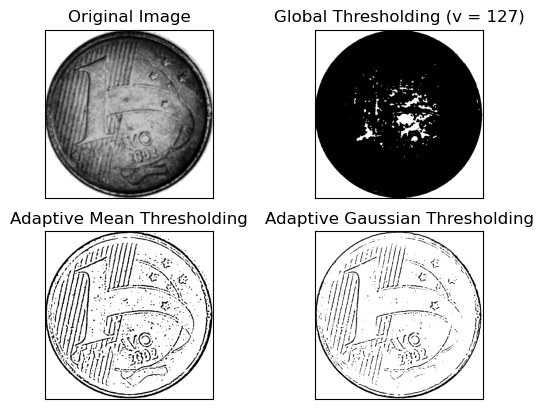

In [285]:
img = cv2.imread(path_images + coin_img, cv2.IMREAD_GRAYSCALE)

# Parametros: imagem e mediana de todos os pixels na área do kernel
img = cv2.medianBlur(img, 5)
img = cv2.equalizeHist(img)
img = cv2.GaussianBlur(img, (5, 5), 0)
img = cv2.GaussianBlur(img, (7, 7), 0)

# Parametros:
# img: caminho da imagem
# 127: valor de threshold 
# 255: valor maximo para usar o tipo de Thresholding 
# cv2.THRESH_BINARY: tipo de Thresholding 
ret, th1 = cv2.threshold(img, 185, 255, cv2.THRESH_BINARY)

# Parametros:
# img: caminho da imagem
# 255: valor atribuído aos número pixels 
# cv2.ADAPTIVE_THRESH_MEAN_C: média da área da vizinhança menos a constante C.
# cv2.THRESH_BINARY: tipo de Thresholding 
# 11: tamanho da vizinhança de pixel que é usada para calcular um valor limite para o pixel
# 2: constante subtraída da média ou média ponderada
th2 = cv2.adaptiveThreshold(img, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11,10)

# Parametros:
# img: caminho da imagem
# 255: valor atribuído aos número pixels 
# ADAPTIVE_THRESH_GAUSSIAN_C: soma ponderada gaussiana dos valores da vizinhança menos a constante C.
# cv2.THRESH_BINARY: tipo de Thresholding 
# 11: tamanho da vizinhança de pixel que é usada para calcular um valor limite para o pixel
# 2: constante subtraída da média ou média ponderada
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,8)

titles = ['Original Image', 'Global Thresholding (v = 127)', 'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']

images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

C:\Users\crist\AppData\Local\Temp\ipykernel_22012\1902598292.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


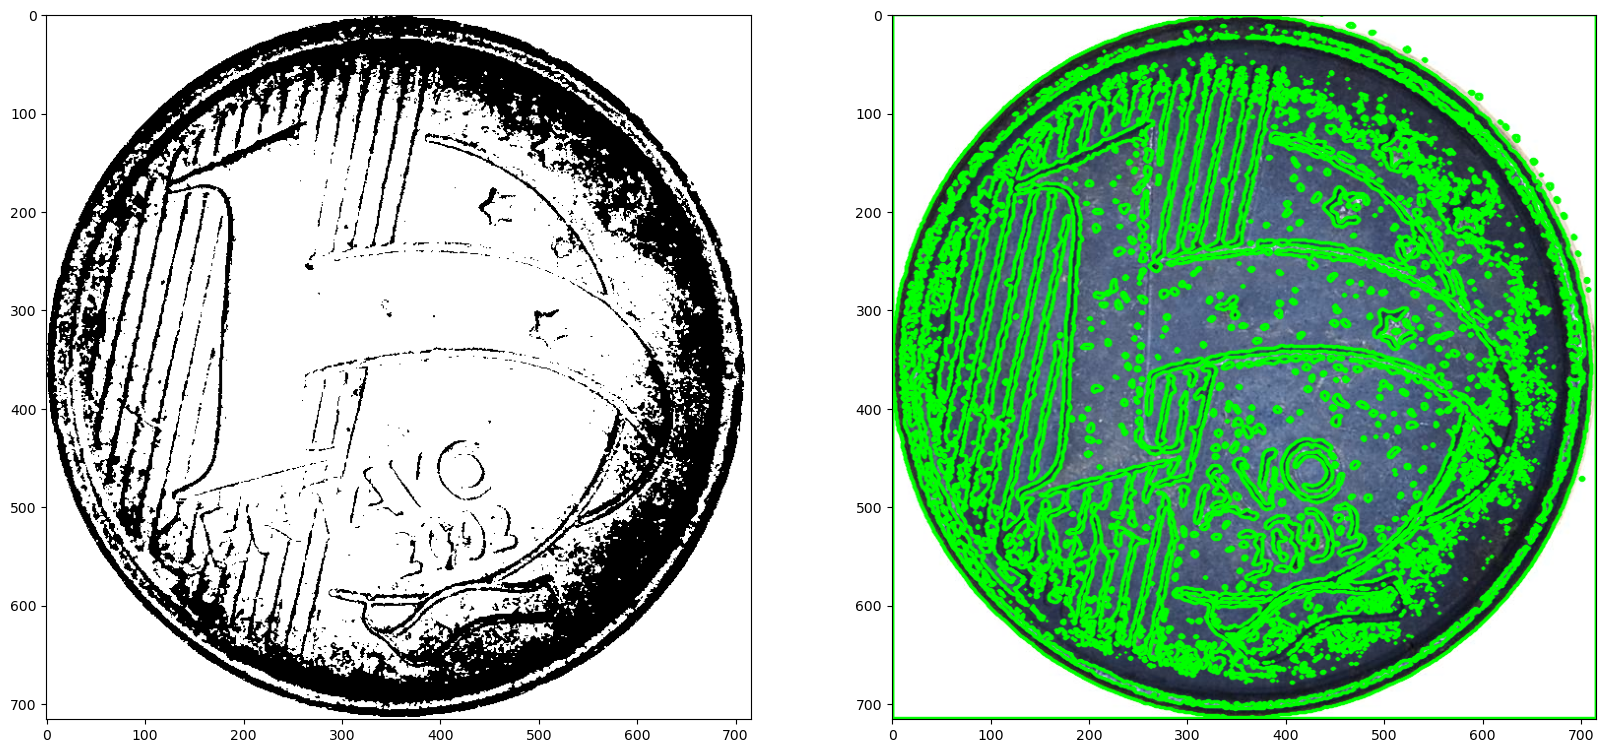

In [286]:
image = cv2.imread(path_images + coin_img)

img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#img_gray = cv2.medianBlur(img_gray, 5)
#img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
#img_gray = img_transform

# Parametros:
# img: caminho da imagem
# 150: valor de threshold 
# 255: valor maximo para usar o tipo de Thresholding 
# cv2.THRESH_BINARY: tipo de Thresholding 
ret, thresh = cv2.threshold(img_gray, 70, 255, cv2.THRESH_BINARY)

# Parametros
# image: caminho da imagem em 8 bits
# mode: modo de recuperação de contorno (RETR_EXTERNAL, RETR_LIST, RETR_CCOMP, RETR_TREE, RETR_FLOODFILL)
# method: método de aproximação de contorno (CHAIN_APPROX_NONE, CHAIN_APPROX_SIMPLE, CHAIN_APPROX_TC89_L1, CHAIN_APPROX_TC89_KCOS)
contours, hierarchy = cv2.findContours(image=thresh*th2, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
#thresh*th2

# Faz copia da imagem original
image_copy = image.copy()

# Desenha contorno na copia da imagem original
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)  

## Bloco para visualização do resultado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(thresh, cmap='gray')
ax2.imshow(image_copy)

fig.show()

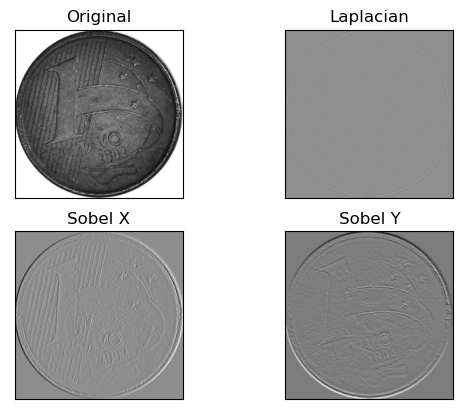

In [287]:
img = cv2.imread(path_images + coin_img, cv2.IMREAD_GRAYSCALE)

# Parametros
# img: caminho da imagem
# cv2.CV_64F: tipo de dados de saída (pode ser utilizado também CV_16S)
# OBs: utilizar CV_8U transforma transição branco-preto em inclinação negativa, o que é zerado pelo filtro
laplacian = cv2.Laplacian(img, cv2.CV_16S)

# Parametros
# img: caminho da imagem
# cv2.CV_64F: tipo de dados de saída (pode ser utilizado também CV_16S)
# 1: ordem da derivada em x (ativado)
# 0: ordem da derivada em y
# ksize: tamanho do kernel
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=9)

# Parametros
# img: caminho da imagem
# cv2.CV_64F: tipo de dados de saída (pode ser utilizado também CV_16S)
# 0: ordem da derivada em x 
# 1: ordem da derivada em y (ativado)
# ksize: tamanho do kernel
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=11)

## Visualização do processamento
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])

img_transform = sobely + 16*thresh - 4*sobelx 
img_transform = cv2.GaussianBlur(img_transform, (5, 5), 0)
plt.subplot(2,2,4),plt.imshow(img_transform, cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

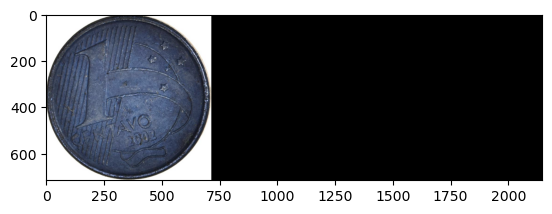

In [312]:
img = cv2.imread(path_images + coin_img, cv2.IMREAD_COLOR) 

# Parametros
# img: caminho da imagem
# 50 (minVal): gradiente de intensidade menor (menor que este valor NÂO É considerado borda)
# 200 (maxVal): gradiente de intensidade maior (maior que este valor É considerado borda)
dst = th3#cv2.Canny(img, 50, 200)

# Copie as bordas para as imagens que exibirão os resultados em RGB
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

# Parametros
# dst: caminho da imagem em 8 bits
# 1: parametro de Threshold 
# np.pi / 180: RHO - resolução da distância do acumulador em pixels.
# 150: Theta - resolução angular do acumulador em radianos.
# 0: divisor para a resolução de distância rho.
# 0: divisor para a resolução de distância theta.
lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        
        a = math.cos(theta)
        b = math.sin(theta)
        
        x0 = a * rho
        y0 = b * rho
        
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

        cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)

# Parametros
# dst: caminho da imagem em 8 bits
# 1: parametro de Threshold 
# np.pi / 180: RHO - resolução da distância do acumulador em pixels.
# 150: Theta - resolução angular do acumulador em radianos.
# 0: divisor para a resolução de distância rho.
# 0: divisor para a resolução de distância theta.
linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, 150, 50, 10)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]

        cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

result = np.concatenate((img, cdst, cdstP), axis=1)

plt.imshow(result,cmap = 'gray')

In [289]:
plt.imsave(path_images + 'tr_' + coin_img, th3, cmap='gray')

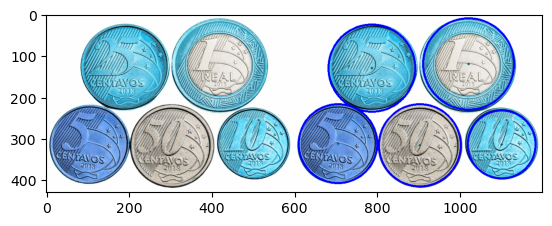

In [374]:
path_images = 'coin_images/test/'
coin_img = 'test_3.jpg'

img = cv2.imread(path_images + coin_img, cv2.IMREAD_COLOR)

imgOriginal = img.copy()

## Escala de cinza
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## Parametros: imagem e mediana de todos os pixels na área do kernel
gray = cv2.medianBlur(gray, 5)

## Coleta a dimensão de largura
rows = gray.shape[0]

# Parametros:
# gray: caminho da imagem
# cv2.HOUGH_GRADIENT: técnica a ser aplicada para detecção
# dp=1: razão inversa da resolução do acumulador em relação a imagem (entre 1 e 2,  quanto maior esse valor, mais sensivel o detector é, podendo causar falsos positivos)
# rows/8: a distância mínima entre dois círculos
# param1=100: é o limite mais alto para o detector de arestas de Canny
# param2=30: é o limite do acumulador para os centros do círculo no estágio de detecção
# minRadius e maxRadius: limites para o tamanho dos círculos a serem detectados
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 60, param1=150, param2=150, minRadius=0, maxRadius=0)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        
        center = (i[0], i[1])

        # Circulos no centro
        cv2.circle(img, center, 1, (0, 100, 100), 3)
        
        # Circulos de fora
        radius = i[2]
        cv2.circle(img, center, radius, (0, 0, 255), 3)

result = np.concatenate((imgOriginal, img), axis=1)

plt.imshow(result)